# Project # 17  Conversation, Capture and Notes, generations during GP clinic visit
At the current stage, we have completed the audio denoising, differentiation of patient and doctor voices, and generation of conversation text, primarily utilizing the Pyannote and Whisper libraries. Specific environmental requirements can be referred to in the requirements.txt file.

# Setup the Environment

In [1]:
!nvidia-smi

Tue Nov 28 14:04:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from IPython.display import HTML, clear_output
!rm -rf /content/sample_data
!mkdir /content/sample_data

!git clone https://github.com/justinjohn0306/Wav2Lip

%cd /content/Wav2Lip

#download the pretrained model
!wget 'https://github.com/justinjohn0306/Wav2Lip/releases/download/models/wav2lip.pth' -O 'checkpoints/wav2lip.pth'
!wget 'https://github.com/justinjohn0306/Wav2Lip/releases/download/models/wav2lip_gan.pth' -O 'checkpoints/wav2lip_gan.pth'
!wget 'https://github.com/justinjohn0306/Wav2Lip/releases/download/models/resnet50.pth' -O 'checkpoints/resnet50.pth'
!wget 'https://github.com/justinjohn0306/Wav2Lip/releases/download/models/mobilenet.pth' -O 'checkpoints/mobilenet.pth'
a = !pip install https://raw.githubusercontent.com/AwaleSajil/ghc/master/ghc-1.0-py3-none-any.whl
!pip install git+https://github.com/elliottzheng/batch-face.git@master

!pip install ffmpeg-python mediapipe==0.8.11

# for elevenlabs
!pip install git+https://github.com/elevenlabs/elevenlabs-python.git

# for moviepy
!pip install moviepy
!pip install pydub SpeechRecognition
!apt install ffmpeg
!pip install gtts

# for subtitle generator
!pip install git+https://github.com/m1guelpf/auto-subtitle.git

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

%cd /
from ghc.l_ghc_cf import l_ghc_cf
%cd content

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr


from IPython.display import HTML
from base64 import b64encode
def showVideo(path):
  mp4 = open(str(path),'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=700 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

from IPython.display import clear_output

clear_output()
print("All set and ready!")

All set and ready!


In [3]:
import os
import shutil
from google.colab import drive
from google.colab import files
from IPython.display import HTML, clear_output
from base64 import b64encode
import moviepy.editor as mp
import cv2
from IPython.display import Audio
from IPython.core.display import display
from google.colab import files
import librosa
import soundfile as s
from IPython.display import Audio
from IPython.core.display import display
from elevenlabs import set_api_key
from elevenlabs import save, generate, play
import uuid
import requests
from datetime import datetime, timedelta
from moviepy.editor import VideoFileClip, concatenate_videoclips
from pydub import AudioSegment
from pydub.silence import split_on_silence
import speech_recognition as sr
from gtts import gTTS
import time
import io
import re

# resolution
import torch

##### Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Text to Avatar

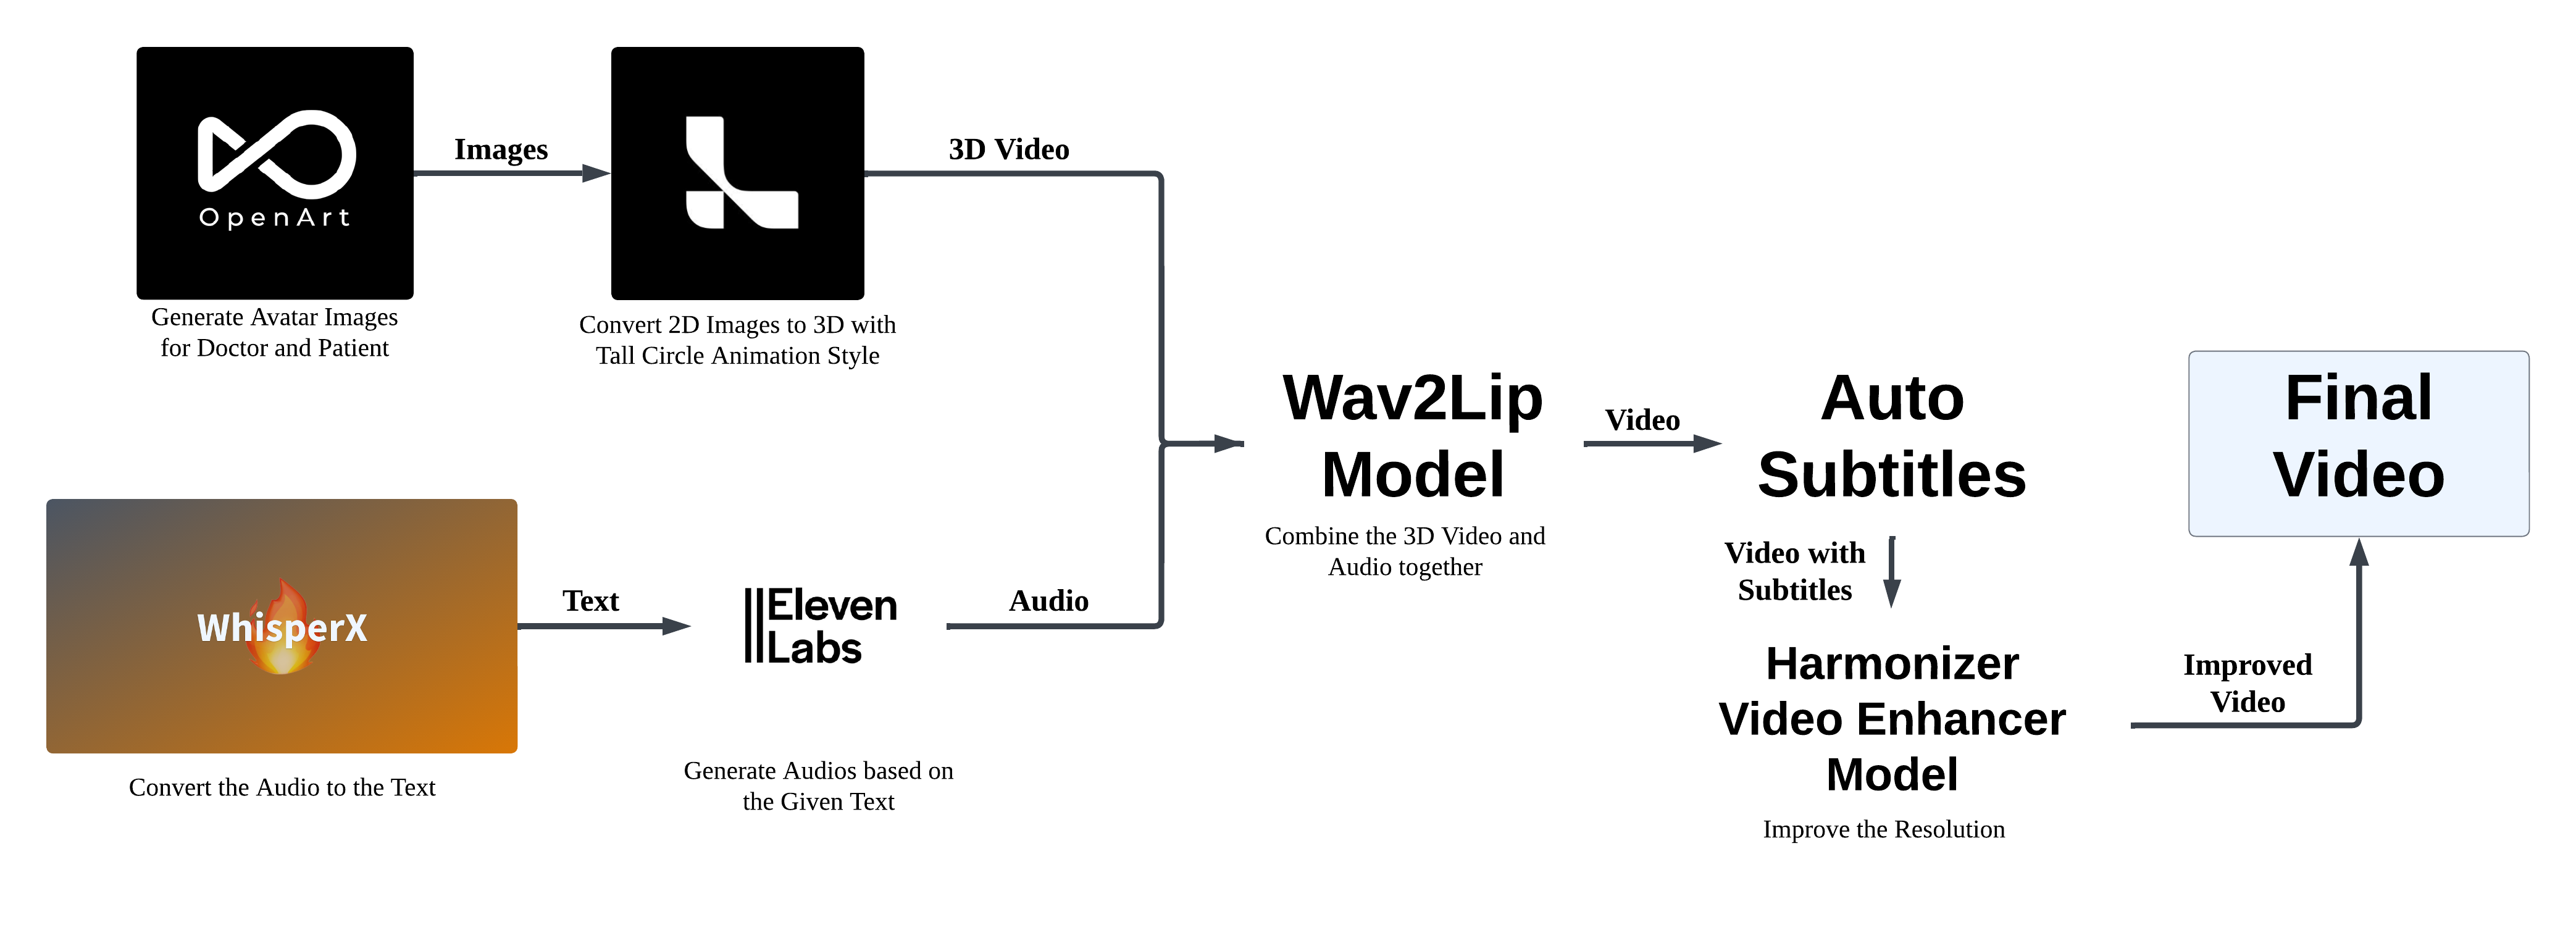

## Text to Audio

In [5]:
with open('/content/drive/MyDrive/DH_Project/transcript.txt', 'r') as file:
    lines = file.readlines()

doctor_dialogue = lines[0].strip()
patient_dialogue = lines[1].strip()
first_speaker = lines[2].strip()

print("Doctor Dialogue:", doctor_dialogue)
print("Patient Dialogue:", patient_dialogue)
print("First Speaker:", first_speaker)

Doctor Dialogue: " Miss X, why are you here today? / Is it a dry cough or with mucus? / How sharp is your breathlessness? / Any previous health conditions? / Any medications? / Any allergies? / Any family health conditions? / Any recent travel exposure? / Do you smoke? / Any alcohol use? / Based on your symptoms, I would like to proceed with testing. Please rest and stay hydrated. / Thank you."
Patient Dialogue: " I have a constant cough and feel out of breath. / Mainly dry cough, but some mornings there's mucus. / It mainly happens when I exert myself. / I have high blood pressure, but it's controlled through diet. / No. / Yes, shellfish. / My mom had migraines in her twenties and my dad has high blood pressure. / Yes, I attended a large wedding two weeks ago. / Yes, half a pack of cigarettes daily. / No, I don't drink. / Okay, thank you, doctor."
First Speaker: "Doctor"


In [6]:
ELEVENLABS_KEY = "1435ec5fa492496fdd1015c8d916b969"
set_api_key(ELEVENLABS_KEY)

In [7]:
def split_into_sentences(text):
    sentences = re.split(r'/', text)
    return [sentence.strip() for sentence in sentences if sentence.strip()]

In [8]:
patient_sentences = split_into_sentences(patient_dialogue)
doctor_sentences = split_into_sentences(doctor_dialogue)
PATIENT_VOICE = "Emily"
DOCTOR_VOICE = "Grace"

## Video Generation

In [9]:
def showVideo(USER_PATH):
    """Function to display video in Colab"""
    if not os.path.isfile(USER_PATH):
        print("ERROR: File not found!")
        raise SystemExit(0)

    mp4 = open(USER_PATH, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML(f"""
    <video controls width=600>
        <source src="{data_url}" type="video/mp4">
    </video>
    """))

def get_video_resolution():
    """Function to get the resolution of a video"""
    video = cv2.VideoCapture(USER_PATH)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    return width, height

def resize_video(new_resolution):
    """Function to resize a video"""
    video = cv2.VideoCapture(USER_PATH)
    fourcc = int(video.get(cv2.CAP_PROP_FOURCC))
    fps = video.get(cv2.CAP_PROP_FPS)
    width, height = new_resolution
    output_path = os.path.splitext(USER_PATH)[0] + '_720p.mp4'
    writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while True:
        success, frame = video.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, new_resolution)
        writer.write(resized_frame)

    video.release()
    writer.release()

In [10]:
def generate_audio_and_video(sentences, voice, video_path, output_folder):
    for i, sentence in enumerate(sentences):
        %cd /content/Wav2Lip
        USER_AUDIOPATH = f'{output_folder}/audio_{i}.wav'
        output_file_path = './results/result_voice.mp4'
        # output_file_path = f'{output_folder}/video_{i}.mp4'
        # ensure_directory_exists(output_file_path)

        audio = generate(
            text=sentence,
            voice=voice,
            model="eleven_multilingual_v2"
        )
        save(audio, USER_AUDIOPATH)

        USER_PATH = video_path

        %cd /content/Wav2Lip
        if os.path.exists(output_file_path):
            os.remove(output_file_path)

        pad_top = 0
        pad_bottom = 10
        pad_left = 0
        pad_right = 0
        rescaleFactor = 1
        nosmooth = True

        use_hd_model = False
        checkpoint_path = 'checkpoints/wav2lip.pth' if not use_hd_model else 'checkpoints/wav2lip_gan.pth'

        if nosmooth == False:
            !python inference.py --checkpoint_path $checkpoint_path --face "$USER_PATH" --audio "$USER_AUDIOPATH" --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor
        else:
            !python inference.py --checkpoint_path $checkpoint_path --face "$USER_PATH" --audio "$USER_AUDIOPATH" --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor --nosmooth

        if os.path.exists(output_file_path):
            clear_output()
            print("Final Video Preview")
            print("Download this video from", output_file_path)
            showVideo(output_file_path)
        else:
            print("Processing failed. Output video not found.")

        new_file_path = f'{output_folder}/video_{i}.mp4'
        shutil.copy(output_file_path, new_file_path)

In [11]:
patient_video_path = '/content/drive/MyDrive/DH_Project/patient_leiapix.mp4'
doctor_video_path = '/content/drive/MyDrive/DH_Project/doctor_leiapix.mp4'

In [12]:
def ensure_directory_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [13]:
ensure_directory_exists('/content/drive/MyDrive/DH_Project/patient')
ensure_directory_exists('/content/drive/MyDrive/DH_Project/doctor')

In [18]:
# generate_audio_and_video(patient_sentences, PATIENT_VOICE, patient_video_path, '/content/drive/MyDrive/DH_Project/patient')
# generate_audio_and_video(doctor_sentences, DOCTOR_VOICE, doctor_video_path, '/content/drive/MyDrive/DH_Project/doctor')

In [16]:
def extract_number(filename):
    numbers = ''.join(filter(str.isdigit, filename))
    return int(numbers) if numbers else None

def cross_concatenate_clips(patient_folder, doctor_folder, output_path):
    clips = []
    patient_files = sorted([f for f in os.listdir(patient_folder) if f.endswith('.mp4')], key=extract_number)
    doctor_files = sorted([f for f in os.listdir(doctor_folder) if f.endswith('.mp4')], key=extract_number)

    max_length = max(len(patient_files), len(doctor_files))

    for i in range(max_length):
        if i < len(patient_files):
            patient_video_path = os.path.join(patient_folder, patient_files[i])
            print(f"Adding patient video: {patient_video_path}")
            clips.append(VideoFileClip(patient_video_path))

        if i < len(doctor_files):
            doctor_video_path = os.path.join(doctor_folder, doctor_files[i])
            print(f"Adding doctor video: {doctor_video_path}")
            clips.append(VideoFileClip(doctor_video_path))

    if clips:
        final_clip = concatenate_videoclips(clips, method="compose")
        final_clip.write_videofile(output_path, codec="libx264", fps=24)
    else:
        print("No video clips found to concatenate.")

In [17]:
if first_speaker == 'Patient':
  cross_concatenate_clips('/content/drive/MyDrive/DH_Project/patient', '/content/drive/MyDrive/DH_Project/doctor', '/content/drive/MyDrive/DH_Project/final_video.mp4')
else:
  cross_concatenate_clips('/content/drive/MyDrive/DH_Project/doctor', '/content/drive/MyDrive/DH_Project/patient', '/content/drive/MyDrive/DH_Project/final_video.mp4')

Adding patient video: /content/drive/MyDrive/DH_Project/doctor/video_0.mp4
Adding doctor video: /content/drive/MyDrive/DH_Project/patient/video_0.mp4
Adding patient video: /content/drive/MyDrive/DH_Project/doctor/video_1.mp4
Adding doctor video: /content/drive/MyDrive/DH_Project/patient/video_1.mp4
Adding patient video: /content/drive/MyDrive/DH_Project/doctor/video_2.mp4
Adding doctor video: /content/drive/MyDrive/DH_Project/patient/video_2.mp4
Adding patient video: /content/drive/MyDrive/DH_Project/doctor/video_3.mp4
Adding doctor video: /content/drive/MyDrive/DH_Project/patient/video_3.mp4
Adding patient video: /content/drive/MyDrive/DH_Project/doctor/video_4.mp4
Adding doctor video: /content/drive/MyDrive/DH_Project/patient/video_4.mp4
Adding patient video: /content/drive/MyDrive/DH_Project/doctor/video_5.mp4
Adding doctor video: /content/drive/MyDrive/DH_Project/patient/video_5.mp4
Adding patient video: /content/drive/MyDrive/DH_Project/doctor/video_6.mp4
Adding doctor video: /con

MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/DH_Project/final_video.mp4



t:   2%|▏         | 31/1271 [00:00<00:14, 84.05it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DH_Project/doctor/video_0.mp4, 691200 bytes wanted but 0 bytes read,at frame 50/55, at time 1.67/1.80 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

t:  10%|▉         | 122/1271 [00:02<00:27, 41.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DH_Project/patient/video_0.mp4, 691200 bytes wanted but 0 bytes read,at frame 99/103, at time 3.30/3.42 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filen

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DH_Project/final_video.mp4


## Subtitle Generation

In [19]:
!auto_subtitle '/content/drive/MyDrive/DH_Project/final_video.mp4' -o '/content/drive/MyDrive/DH_Project/subtitled/'

100%|████████████████████████████████████████| 461M/461M [00:04<00:00, 102MiB/s]
Extracting audio from final_video...
Generating subtitles for final_video... This might take a while.
Detected language: English
100% 5295/5295 [00:06<00:00, 855.13frames/s]
Adding subtitles to final_video...
Saved subtitled video to /content/drive/MyDrive/DH_Project/subtitled/final_video.mp4.


## Resolution Improvement

In [20]:
%cd /content/Wav2Lip

/content/Wav2Lip


In [21]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

--2023-11-28 14:12:25--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120986213 (115M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>] 115.38M   106MB/s    in 1.1s    

2023-11-28 14:12:26 (106 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [120986213/120986213]

PREFIX=/usr/local
Unpacking payload ...
                                                                                   
Installing base environment...





Preparing transaction: - \ | / - \ | / - done
Executing transaction: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / 

In [22]:
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages/')

In [23]:
!git clone https://github.com/ZHKKKe/Harmonizer.git
%cd Harmonizer

Cloning into 'Harmonizer'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 166 (delta 20), reused 67 (delta 8), pack-reused 74
Receiving objects: 100% (166/166), 53.66 MiB | 34.28 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/Wav2Lip/Harmonizer


In [24]:
!conda create -n harmonizer python=3.8 -y
!echo "source activate harmonizer" > ~/.bashrc
!source ~/.bashrc

Channels:
 - defaults
Platform: linux-64
Solving environment: | done

## Package Plan ##

  environment location: /usr/local/envs/harmonizer

  added / updated specs:
    - python=3.8


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pip-23.3.1                 |   py38h06a4308_0         2.6 MB
    python-3.8.18              |       h955ad1f_0        25.3 MB
    setuptools-68.0.0          |   py38h06a4308_0         927 KB
    wheel-0.41.2               |   py38h06a4308_0         108 KB
    ------------------------------------------------------------
                                           Total:        28.9 MB

The following NEW packages will be INSTALLED:

  _libgcc_mutex      pkgs/main/linux-64::_libgcc_mutex-0.1-main 
  _openmp_mutex      pkgs/main/linux-64::_openmp_mutex-5.1-1_gnu 
  ca-certificates    pkgs/main/linux-64::ca-certificates-2023.08.22-h06a4308_0 
  ld_impl_linux-64 

In [ ]:
!pip install -r src/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 284.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 91.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 89.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5

In [ ]:
!mkdir -p ./demo/video_enhancement/example
!cp /content/drive/MyDrive/DH_Project/subtitled/final_video.mp4 ./demo/video_enhancement/example/

In [ ]:
%env PYTHONPATH=

In [ ]:
!pip install opencv-python-headless

In [ ]:
!pip install torchvision

In [ ]:
!python -m demo.video_enhancement.run --example-path ./demo/video_enhancement/example

In [ ]:
!cp ./demo/video_enhancement/example/final_video.mp4 /content/drive/MyDrive/DH_Project/final_video_enhanced_cap.mp4

In [33]:
from matplotlib import pyplot as plt
from IPython.display import display, Video
display(Video('/content/drive/MyDrive/DH_Project/final_video_enhanced_cap.mp4', embed=True))

Output hidden; open in https://colab.research.google.com to view.